In [10]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt

# Plot utils

In [11]:
def plot_scatter(x, y, centres=None):
  fig = plt.figure(figsize=(10,10))
  plt.scatter(x[:,0], x[:,1], c=y, alpha=0.7, s=20);

  if centres is not None:
    n_centres = len(centres)
    for i, c in enumerate(centres):
      plt.scatter(c[:,0], c[:,1], c=np.arange(c.shape[0]), marker='*', s=1000, alpha=(i+1)/n_centres)
  plt.show();

def plot_scatter_by_weights(x, weights, centres=None, color_base=None):
  n_clusters = weights.shape[1]
  if color_base is None:
    color_base = np.arange(n_clusters)

  fig = plt.figure(figsize=(10,10))
  plt.scatter(x[:,0], x[:,1], c=weights.dot(color_base), alpha=0.7, s=20);

  if centres is not None:
    n_centres = len(centres)
    for i, c in enumerate(centres):
      plt.scatter(c[:,0], c[:,1], c=color_base, marker='*', s=1000, alpha=(i+1)/n_centres)
  plt.show();

def plot_scatter_history(x, clusters_hist, weight_hist, centres_hist=None, color_base=None):
  iters = len(clusters_hist)
  assert len(clusters_hist) == len(centres_hist)

  fig_n_cols = 4
  fig_n_rows = (iters // 4) + 1

  n_clusters = weight_hist[-1].shape[1]
  if color_base is None:
    color_base = np.arange(n_clusters)

  plt.figure(figsize=(8 * fig_n_cols, 8 * fig_n_rows))
  for i in range(iters):
    plt.subplot(fig_n_rows, fig_n_cols, i+1)
    plt.scatter(x[:,0], x[:,1], c=weight_hist[i].dot(color_base), alpha=0.7, s=20);
    plt.scatter(centres_hist[i][:,0], centres_hist[i][:,1], c=color_base, marker='*', s=1000)
    plt.title(f'iteration {i}')
  plt.show();

# Score and cost calculation


In [12]:
def purity_soft_cost(y, weights):
  n_clusters = weights.shape[1]
  clusters_purity = []
  for c1 in range(n_clusters):
    one_class_putiry = []
    for c2 in range(n_clusters):
      one_class_putiry.append(np.sum(weights[y==c2, c1]))
    clusters_purity.append(np.max(one_class_putiry))
  return np.sum(clusters_purity) / len(y)

def calc_purity_soft_hist(y, weights_hist):
  putiry_hist = []
  for r in weights_hist:
    putiry_hist.append(purity_soft_cost(y, r))
  return putiry_hist

In [13]:
def davis_bouldin_index_soft_cost(x, weights, cluster_centres, dist_calc_func):
  K = len(cluster_centres)
  sigma = np.zeros(K)
  for k in range(K):
    d = weights[:, k] * dist_calc_func(x - cluster_centres[k])
    sigma[k] = np.sqrt(d.sum() / weights[:, k].sum())
  
  clusters_divergence = []
  for i in range(K):
    one_class_divergence = []
    for j in range(K):
      if i != j:
        dc = np.sqrt(dist_calc_func(cluster_centres[i] - cluster_centres[j]))
        one_class_divergence.append((sigma[i] + sigma[j]) / dc)
    clusters_divergence.append(np.max(one_class_divergence))
  return np.mean(clusters_divergence)

def calc_davis_bouldin_index_soft_hist(x, weights_hist, centres_hist, dist_calc_func):
  index_hist = []
  for i in range(len(weights_hist)):
    index_hist.append(davis_bouldin_index_soft_cost(x, weights_hist[i], centres_hist[i], dist_calc_func))
  return index_hist

# Kmeans algorithm

In [14]:
def find_centres_weighted(x, r):
  assert x.shape[0] == r.shape[0]
  mu = r.T.dot(x) / r.sum(axis=0, keepdims=True).T
  return mu

norm_vec = np.vectorize(lambda x: x.dot(x), signature='(d)->()')

def assign_cluster_responsibilities(x, centres, beta):
  assert x.shape[1:] == centres.shape[1:]
  N = x.shape[0]
  D = x.shape[1]
  K = centres.shape[0]

  d = np.zeros((N, K))
  exp_ = np.zeros((N, K))
  for k in range(centres.shape[0]):
    diff = x - centres[k]
    d_norm = norm_vec(diff)
    d[:,k] = norm_vec(diff)
    exp_[:,k] = np.exp(-beta * d[:,k])
    
  r = exp_ / exp_.sum(axis=1, keepdims=True)
  clossest_centre = r.argmax(axis=1)
  cost = np.sum(r * d)

  return clossest_centre, r, cost

def k_means_soft_step(x, centres, beta):
  clusters, weights, cost = assign_cluster_responsibilities(x, centres, beta=beta)
  new_centres = find_centres_weighted(x, weights)
  return clusters, new_centres, weights, cost

def k_means_soft(x, initial_centres, beta, max_steps=None, logging_step=None):
  assert x.shape[1] == initial_centres.shape[1]

  centres_hist = [initial_centres]
  weights_hist = []
  clusters_hist = []
  cost_hist = []
  step = 0
  while True:
    if logging_step is not None and step % logging_step == 0:
      print('step:', step)
    if max_steps is not None and step > max_steps:
      print(f'early stop after {step+1} steps - reached maximum number of steps')
      break
    clusters, new_centres, new_weights, cost = k_means_soft_step(x, centres_hist[-1], beta=beta)
    clusters_hist.append(clusters)
    centres_hist.append(new_centres)
    weights_hist.append(new_weights)
    cost_hist.append(cost)
    step += 1

    if step > 1 and np.array_equal(clusters_hist[-2], clusters_hist[-1]):
      print(f'early stop after {step} steps - assigned clusters has not changed')
      break
  
  return clusters_hist, weights_hist, centres_hist, cost_hist

# Load data

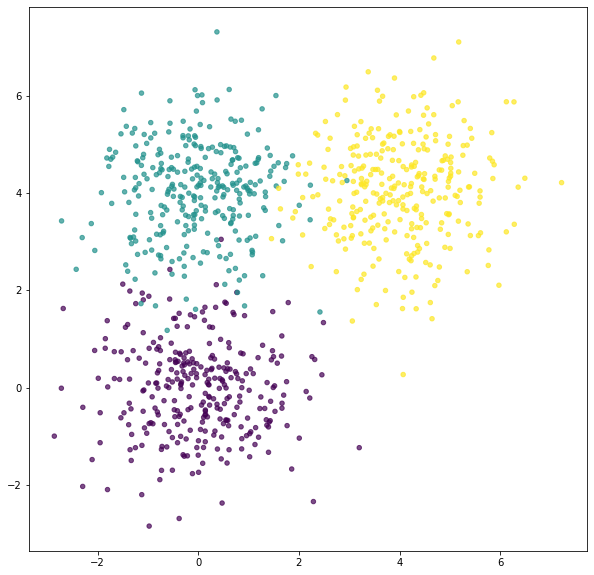

In [15]:
N = 900
D = 2
K = 3
shift = 4
BASE_COLOR = np.random.random((K, 3))

mu0 = np.array([0,0])
mu1 = np.array([0,shift])
mu2 = np.array([shift,shift])

X = np.random.randn(N, D)
X[:300] += mu0
X[300:600] += mu1
X[600:] += mu2

y = np.array([0] * 300 + [1] * 300 + [2] * 300)

ids = np.arange(N)
np.random.shuffle(ids)
X = X[ids]
y = y[ids]

plot_scatter(X, y)

[[0.35077542 0.72791307]
 [0.34261033 3.64984891]
 [3.273749   3.67804357]]


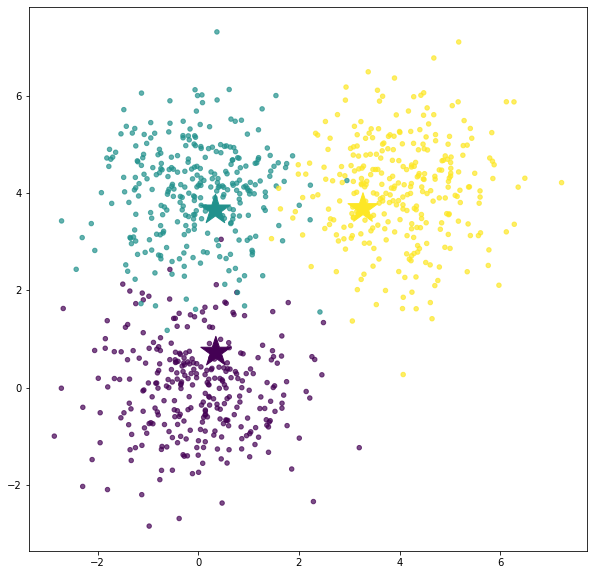

In [16]:
r0 = np.random.uniform(size=(N, K)) * 0.2
r0[:300, 0] = r0[:300, 0] + 0.8
r0[300:600, 1] = r0[300:600, 1] + 0.8
r0[600:, 2] = r0[600:, 2] + 0.8
r0 = r0[ids]

mu0 = find_centres_weighted(X, r0)
print(mu0)
plot_scatter(X, y, [mu0])

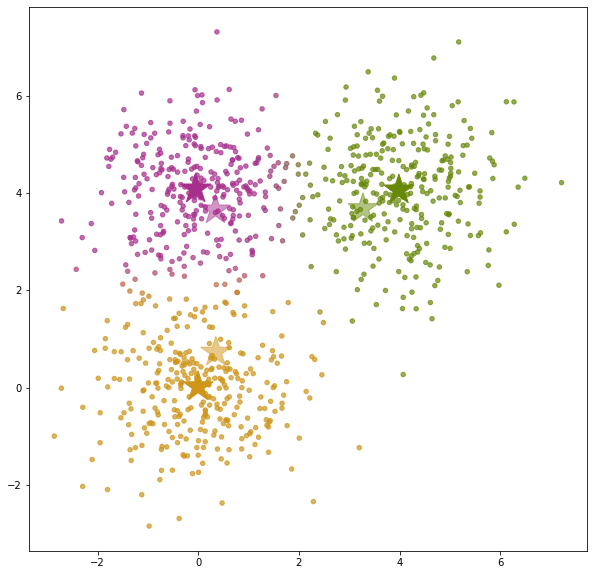

In [17]:
clusters, r, _ = assign_cluster_responsibilities(X, mu0, beta=1.0)
mu1 = find_centres_weighted(X, r)

plot_scatter_by_weights(X, r, centres=[mu0, mu1], color_base=BASE_COLOR)

# Kmeans on genereated data

step: 0
early stop after 7 steps - assigned clusters has not changed


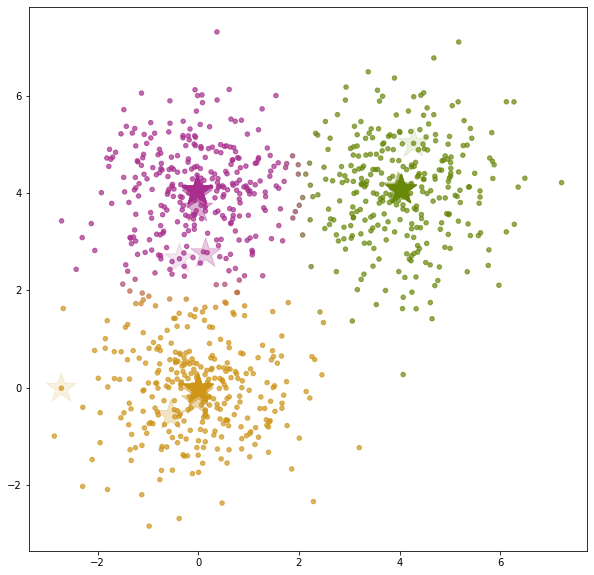

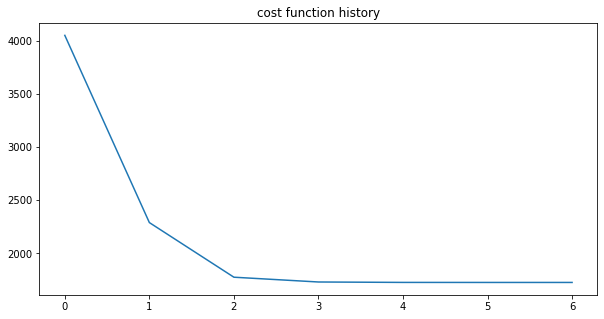

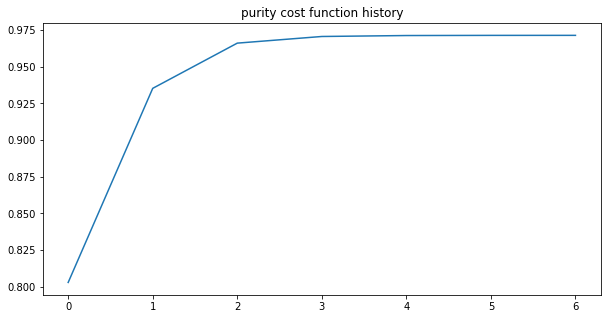

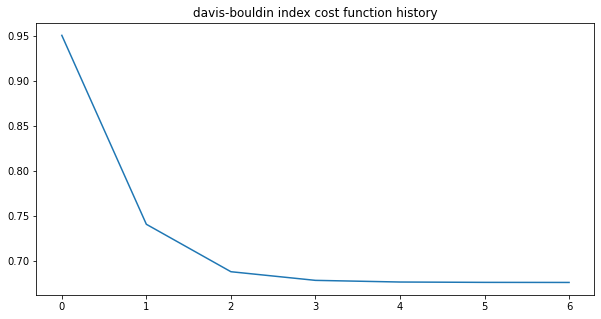

In [18]:
shuffle_ids = np.arange(N)
np.random.shuffle(shuffle_ids)
centres0 = X[shuffle_ids[:3]]

clusters_hist, r_hist, centres_hist, cost_hist = k_means_soft(X, centres0, beta=1.0, max_steps=100, logging_step=10)
plot_scatter_by_weights(X, r_hist[-1], centres_hist, color_base=BASE_COLOR)

plt.figure(figsize=(10,5))
plt.plot(cost_hist)
plt.title('cost function history');
plt.show()

purity_hist = calc_purity_soft_hist(y, r_hist)
plt.figure(figsize=(10,5))
plt.plot(purity_hist)
plt.title('purity cost function history')
plt.show();

purity_hist = calc_davis_bouldin_index_soft_hist(X, r_hist, centres_hist[1:], norm_vec)
plt.figure(figsize=(10,5))
plt.plot(purity_hist)
plt.title('davis-bouldin index cost function history')
plt.show();

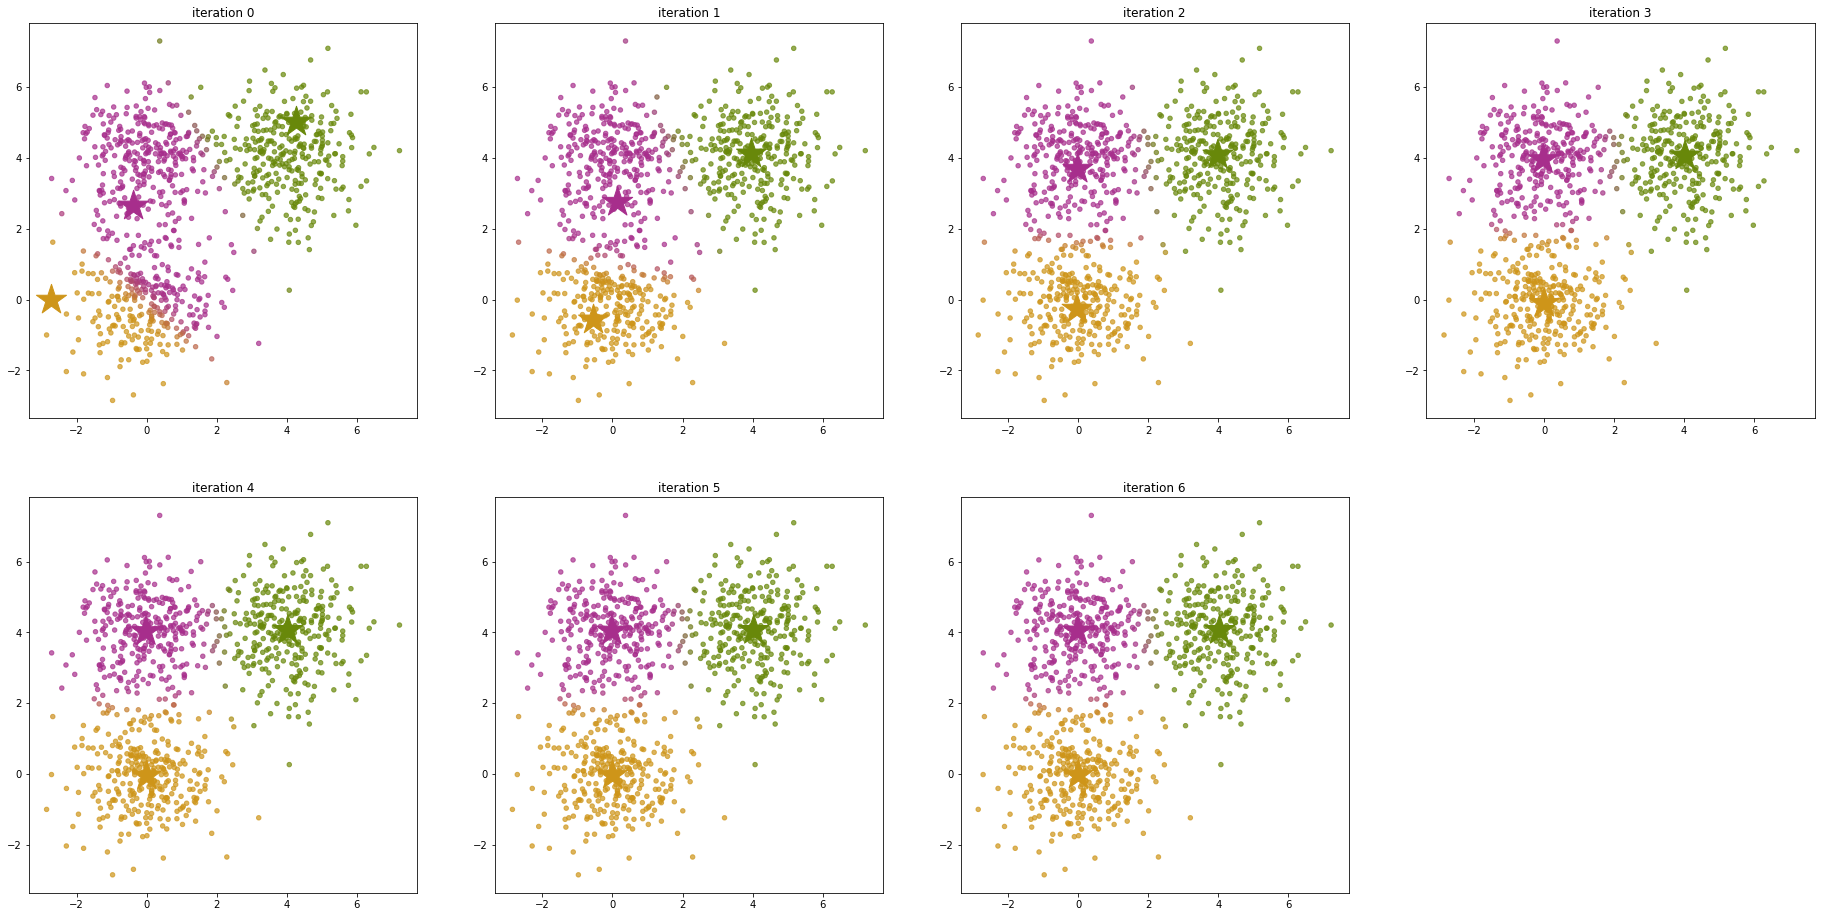

In [19]:
plot_scatter_history(X, clusters_hist, r_hist, centres_hist[:-1], color_base=BASE_COLOR)

# Kmeans on MNIST data set

In [20]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#def get_mnist():
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

mnist_df.head()

Mounted at /content/gdrive/
There is no NA values


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
def plot_examples(x, y, cmap='gray', labels=None):
  plt.figure(figsize=(15,15))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=cmap)
      if labels==None:
        plt.xlabel(y[i])
      else:
        plt.xlabel(labels[y[i]])
  plt.show()


def shuffle_pairs(X, Y):
  N = len(X)
  indexes = np.arange(N)
  np.random.shuffle(indexes)
  X = X[indexes]
  Y = Y[indexes]
  return X, Y


def get_mnist_data(should_shuffle = True, should_plot_examples=True):
  mnist_data = mnist_df.copy().values
  if (should_shuffle == True):
    np.random.shuffle(mnist_data)
  Y_mnist = mnist_data[:, 0]
  X_mnist = np.divide(mnist_data[:, 1:], 255.0)
  picture_shape = (28, 28)

  if (should_plot_examples == True):
    plot_examples(X_mnist.reshape((-1, *picture_shape)), Y_mnist, cmap='gray', labels=None)
  return X_mnist, Y_mnist, picture_shape

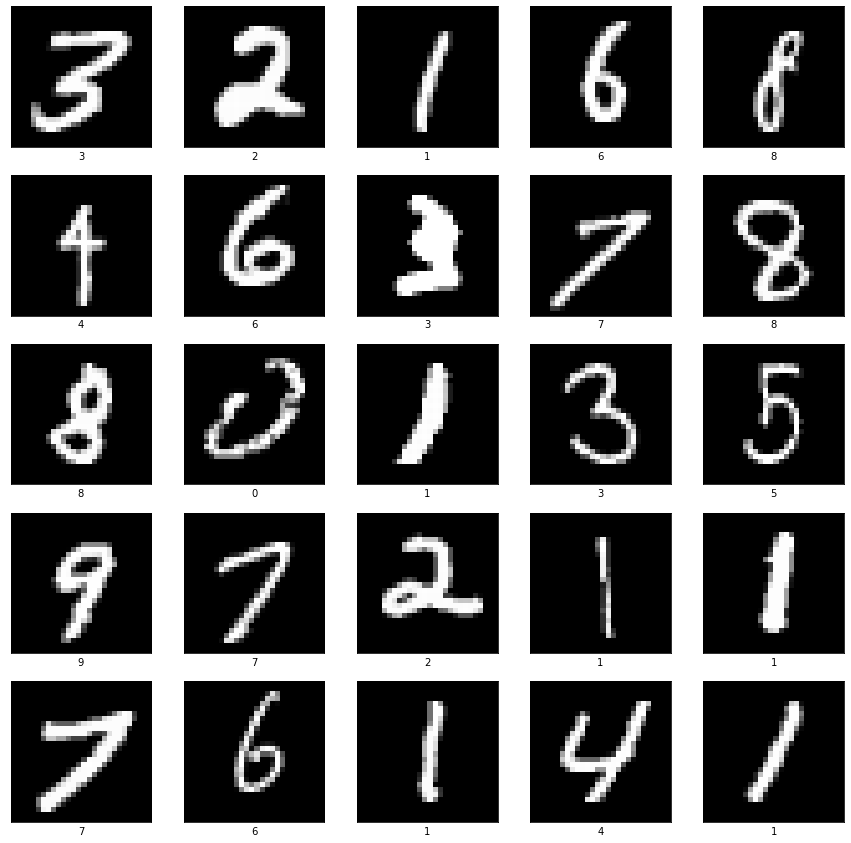

In [22]:
Nmnist = 1000

Xmnist, Ymnist, pic_shape = get_mnist_data()
Xmnist = Xmnist[:Nmnist]
Ymnist = Ymnist[:Nmnist]

step: 0
step: 10
step: 20
step: 30
step: 40
early stop after 48 steps - assigned clusters has not changed


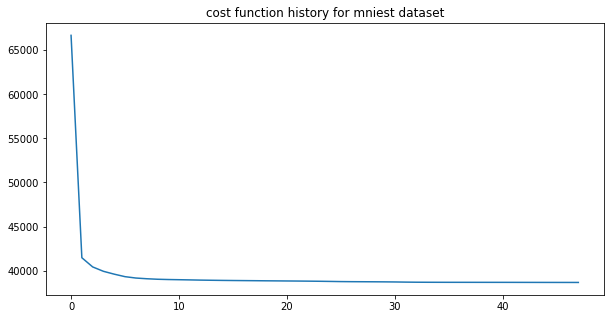

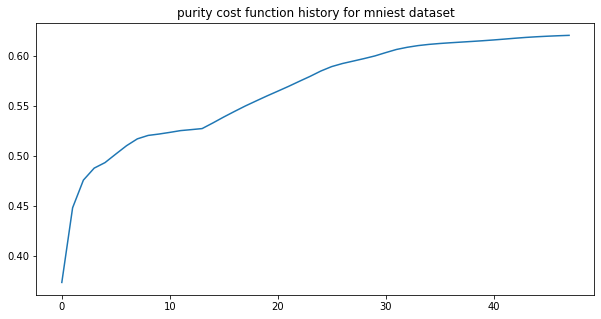

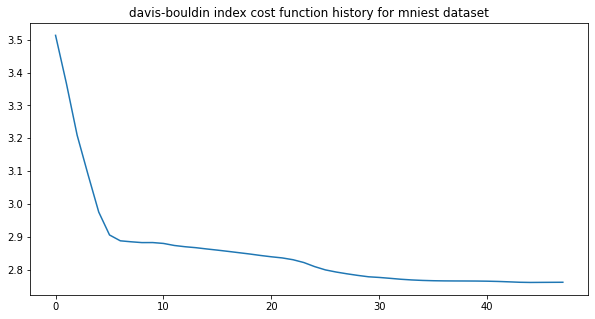

In [23]:
Kmnist = 10

shuffle_ids = np.arange(Nmnist)
np.random.shuffle(shuffle_ids)
centres0_mnist = Xmnist[shuffle_ids[:Kmnist]]

mnist_clusters_hist, mnist_r_hist, mnist_centres_hist, mnist_cost_hist = k_means_soft(Xmnist, centres0_mnist, beta=1.0, max_steps=100, logging_step=10)
#MNIST_BASE_COLOR = np.random.random((Kmnist, 3))
#plot_scatter_by_weights(Xmnist, mnist_r_hist[-1], mnist_centres_hist, color_base=MNIST_BASE_COLOR)

plt.figure(figsize=(10,5))
plt.plot(mnist_cost_hist)
plt.title('cost function history for mniest dataset');
plt.show()

mnist_purity_hist = calc_purity_soft_hist(Ymnist, mnist_r_hist)
plt.figure(figsize=(10,5))
plt.plot(mnist_purity_hist)
plt.title('purity cost function history for mniest dataset')
plt.show()

mnist_dbi_hist = calc_davis_bouldin_index_soft_hist(Xmnist, mnist_r_hist, mnist_centres_hist[1:], norm_vec)
plt.figure(figsize=(10,5))
plt.plot(mnist_dbi_hist)
plt.title('davis-bouldin index cost function history for mniest dataset')
plt.show();

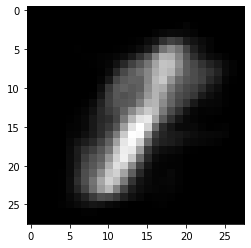

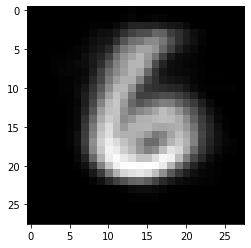

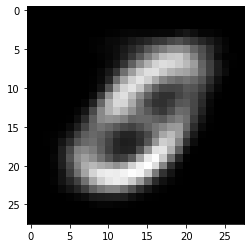

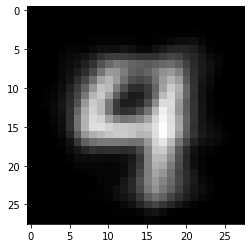

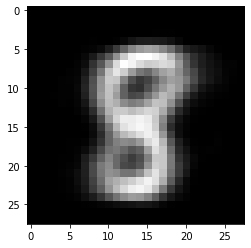

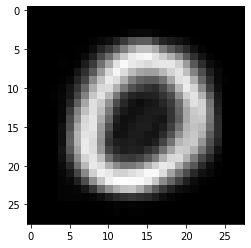

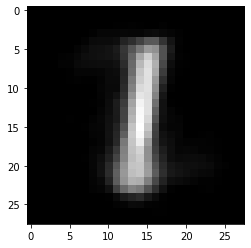

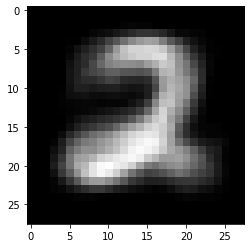

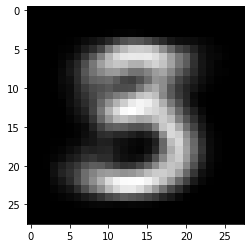

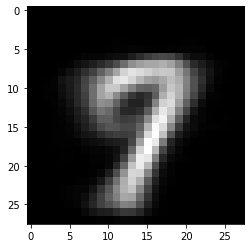

In [24]:
# plot the mean images
# they should look like digits
for k in range(len(mnist_centres_hist[-1])):
  im = mnist_centres_hist[-1][k].reshape(28, 28)
  plt.imshow(im, cmap='gray')
  plt.show()